# LPM Histogram Visualization

In [1]:
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import importlib

## Load the emission distribution file

In [2]:
import struct

def load_histogram4d(fname):
    f = open(fname, 'rb')
    num_lights = struct.unpack('N', f.read(8))[0]
    print(str(num_lights))
    
    light_dist = np.fromfile(f, dtype=np.float32, count=num_lights)
    print (light_dist)
    
    lights = []
    for lid in range(0, num_lights):
        res_pos_u = struct.unpack('i', f.read(4))[0]
        res_pos_v = struct.unpack('i', f.read(4))[0]
        res_dir_u = struct.unpack('i', f.read(4))[0]
        res_dir_v = struct.unpack('i', f.read(4))[0]
        print(str(res_pos_u) + "x" + str(res_pos_v) + "x" + str(res_dir_u) + "x" + str(res_dir_v))
        oned = np.fromfile(f, dtype=np.float32, count=res_pos_u * res_pos_v * res_dir_u * res_dir_v)
        fourd = oned.reshape(res_pos_u, res_pos_v, res_dir_u, res_dir_v)
        lights.append(fourd)
    return (lights, light_dist)

hist_contrib, contrib_lsw = load_histogram4d('../../emdist_contrib.hist')
hist_useful , useful_lsw  = load_histogram4d('../../emdist.hist')

1
[  5.87900736e+08]
1x1x256x256
1
[  3.99822336e+08]
1x1x256x256


In [3]:
def pos_marginal(hist):
    return np.sum(hist, axis=(2,3))

def dir_marginal(hist):
    return np.sum(hist, axis=(0,1))

pos_marginals_useful = []
dir_marginals_useful = []
for i in range(0, len(hist_useful)):
    pos_marginals_useful.append(pos_marginal(hist_useful[i]))
    dir_marginals_useful.append(dir_marginal(hist_useful[i]))
    
pos_marginals_contrib = []
dir_marginals_contrib = []
for i in range(0, len(hist_contrib)):
    pos_marginals_contrib.append(pos_marginal(hist_contrib[i]))
    dir_marginals_contrib.append(dir_marginal(hist_contrib[i]))

## Plotting
First, we generate a colormap that more clearly differentiates between weights that are very low and those that are exactly zero.

<IPython.core.display.Javascript object>


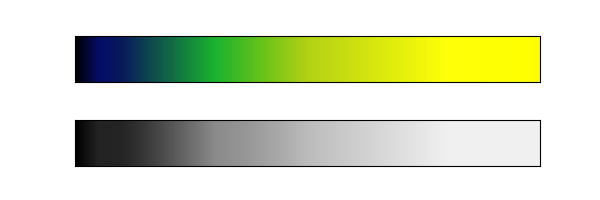

<IPython.core.display.Javascript object>


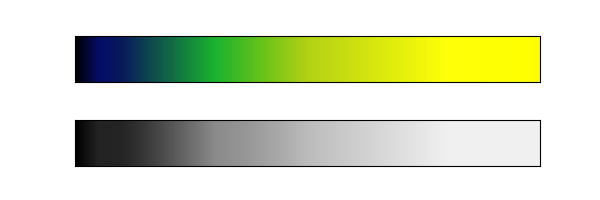

In [4]:
def grayscale_cmap(cmap):
    """Return a grayscale version of the given colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    # convert RGBA to perceived grayscale luminance
    # cf. http://alienryderflex.com/hsp.html
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]
        
    return clr.LinearSegmentedColormap.from_list(cmap.name + "_gray", colors, cmap.N)

def view_colormap(cmap):
    """Plot a colormap with its grayscale equivalent"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    cmap = grayscale_cmap(cmap)
    grayscale = cmap(np.arange(cmap.N))
    
    fig, ax = plt.subplots(2, figsize=(6, 2),
                           subplot_kw=dict(xticks=[], yticks=[]))
    ax[0].imshow([colors], extent=[0, 10, 0, 1])
    ax[1].imshow([grayscale], extent=[0, 10, 0, 1])
    
wmap_clrs = {
    'red':   ((0.0, 0.0, 0.0),
              (0.3, 0.1, 0.1),
              (0.5, 0.7, 0.7),
              (0.8, 1.0, 1.0),
              (1.0, 1.0, 1.0)),
    'green': ((0.0, 0.0, 0.0),
              (0.1, 0.1, 0.1),
              (0.3, 0.7, 0.7),
              (0.8, 1.0, 1.0),
              (1.0, 1.0, 1.0)),
    'blue':  ((0.0, 0.0, 0.0),
#               (0.01, 0.5, 0.5),
              (0.05, 0.4, 0.4),
              (0.4, 0.1, 0.1),
              (1.0, 0.0, 0.0)),
}

weightmap = clr.LinearSegmentedColormap('weightmap', wmap_clrs, N=500)
weightmap.set_bad(color='red')
plt.register_cmap(cmap=weightmap)
view_colormap('weightmap')

# used_cmap = 'gray'
# used_cmap = 'viridis'
used_cmap = 'weightmap'
# used_cmap = 'jet'
plt.set_cmap(used_cmap)
view_colormap(used_cmap)

<IPython.core.display.Javascript object>


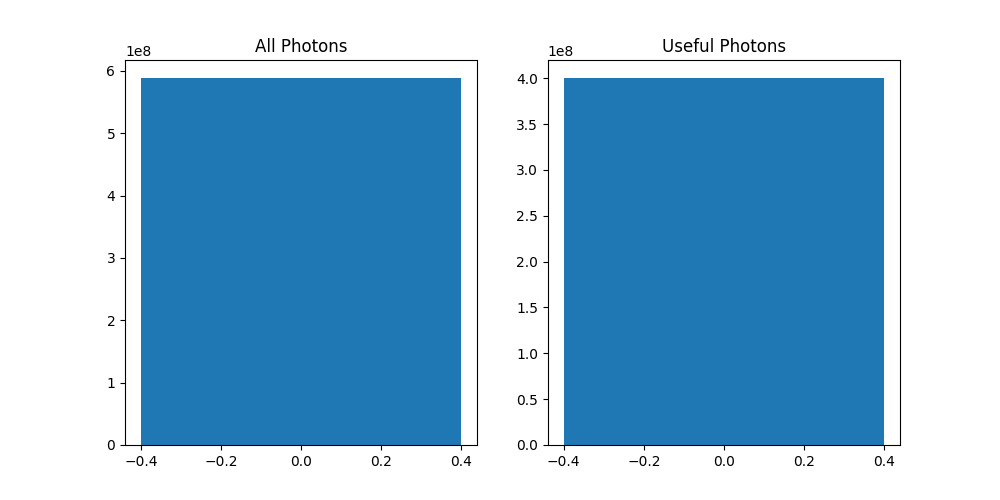

Text(0.5,1,'Useful Photons')

In [5]:
fig, (left, right) = plt.subplots(ncols=2, figsize=(10, 5))
left.bar(np.arange(len(contrib_lsw)), contrib_lsw)
right.bar(np.arange(len(useful_lsw)), useful_lsw)
left.set_title('All Photons')
right.set_title('Useful Photons')

<IPython.core.display.Javascript object>


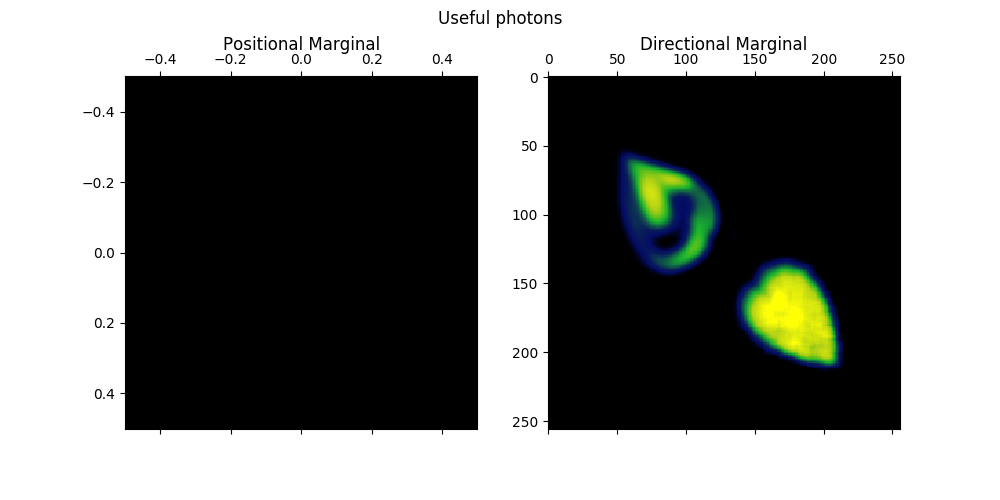

interactive(children=(IntSlider(value=0, description='lid', max=0), Output()), _dom_classes=('widget-interact'…

<function __main__.plot_our_hist(lid, left, right)>

In [6]:
def plot_our_hist(lid, left, right):
    left.matshow(pos_marginals_useful[lid])
    right.matshow(dir_marginals_useful[lid])
    left.set_title('Positional Marginal')
    right.set_title('Directional Marginal')

num_lights = len(hist_useful)
fig, (left, right) = plt.subplots(ncols=2, figsize=(10, 5))
fig.suptitle('Useful photons')
interact(plot_our_hist, lid=(0, num_lights - 1), left=fixed(left), right=fixed(right))

<IPython.core.display.Javascript object>


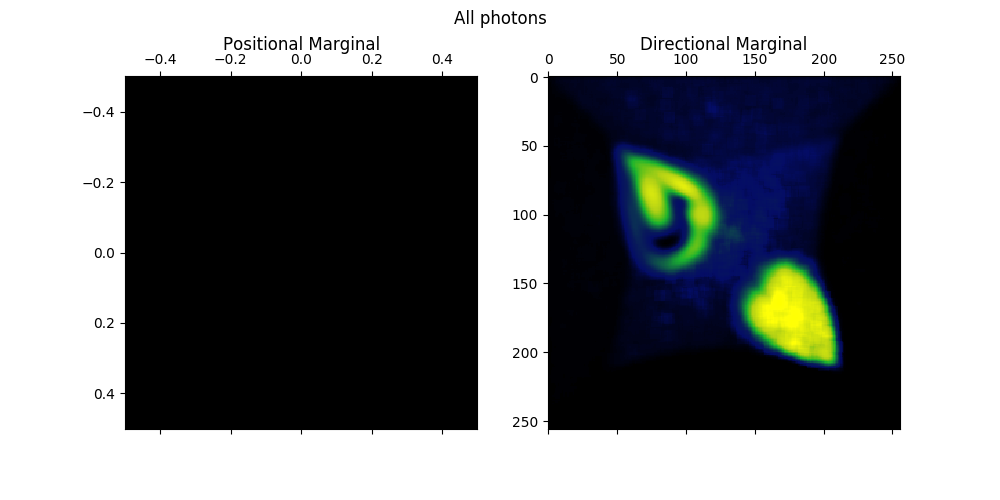

interactive(children=(IntSlider(value=0, description='lid', max=0), Output()), _dom_classes=('widget-interact'…

<function __main__.plot_all_hist(lid, left, right)>

In [7]:
def plot_all_hist(lid, left, right):
    left.matshow(pos_marginals_contrib[lid])
    right.matshow(dir_marginals_contrib[lid])
    left.set_title('Positional Marginal')
    right.set_title('Directional Marginal')

fig, (left, right) = plt.subplots(ncols=2, figsize=(10, 5))
fig.suptitle('All photons')
interact(plot_all_hist, lid=(0, num_lights - 1), left=fixed(left), right=fixed(right))

This code allows exploring the full 4D histogram by selecting a (u,v) coordinate for the position and showing the corresponding directional histogram.

<IPython.core.display.Javascript object>


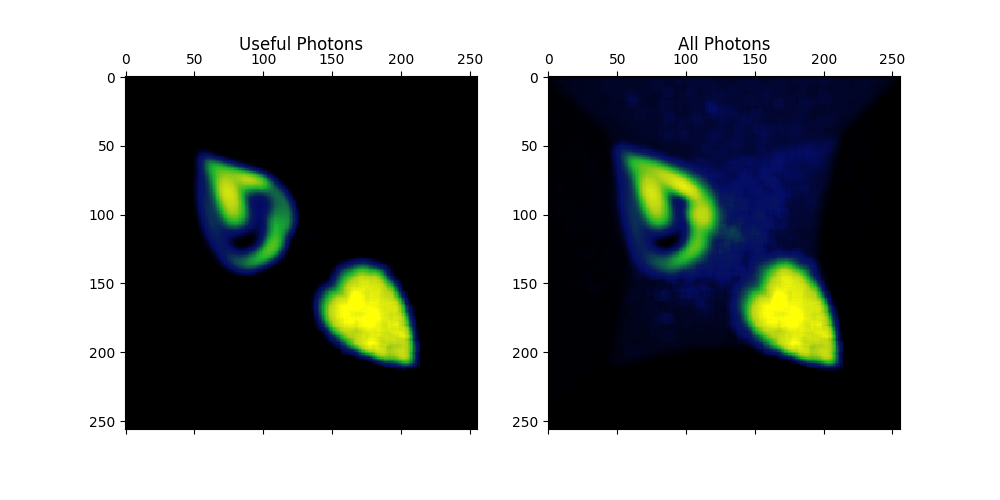

interactive(children=(IntSlider(value=0, description='lid', max=0), IntSlider(value=0, description='ubin', max…

<function __main__.dirplot(left, right, lid, ubin, vbin)>

In [8]:
def dirplot(left, right, lid, ubin, vbin):
    left.matshow(hist_useful[lid][ubin][vbin])
    right.matshow(hist_contrib[lid][ubin][vbin])
    left.set_title("Useful Photons")
    right.set_title("All Photons")
    
fig, (left, right) = plt.subplots(ncols=2, figsize=(10, 5))

num_lights = len(hist_useful)
lid_widget = IntSlider(min=0, max=num_lights - 1)
u_widget = IntSlider(min=0, max=hist_useful[0].shape[0] - 1)
v_widget = IntSlider(min=0, max=hist_useful[0].shape[1] - 1)

def update_uv_range(*args):
    u_widget.max = hist_useful[lid_widget.value].shape[0] - 1
    v_widget.max = hist_useful[lid_widget.value].shape[1] - 1
lid_widget.observe(update_uv_range, 'value')

interact(dirplot, lid=lid_widget, ubin=u_widget, vbin=v_widget, left=fixed(left), right=fixed(right))

In [9]:
np.argwhere(np.isnan(hist_contrib[0]))

array([], shape=(0, 4), dtype=int64)